# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [132]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from phik import phik_matrix
import psycopg2

In [133]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [134]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [135]:
engine = create_engine(connection_string)

In [136]:
# Создание запроса

query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
    SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk,
    created_ts_msk,
    currency_code,
    revenue,
    tickets_count,
    CASE
        WHEN prev_order_date IS NULL THEN NULL
        ELSE (created_dt_msk::date - prev_order_date)::int
    END AS days_since_prev,
    event_id,
    event_name_code AS event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM (
    SELECT
        p.user_id,
        p.device_type_canonical,
        p.order_id,
        p.created_dt_msk,
        p.created_ts_msk,
        p.currency_code,
        p.revenue,
        p.tickets_count,
        p.event_id,
        e.event_name_code,
        e.event_type_main,
        p.service_name AS service_name,
        r.region_name,
        c.city_name,
        LAG(p.created_dt_msk::date)
            OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk) AS prev_order_date
    FROM afisha.purchases p
    INNER JOIN afisha.events e   ON p.event_id = e.event_id
    INNER JOIN afisha.city c    ON e.city_id = c.city_id
    INNER JOIN afisha.regions r ON c.region_id = r.region_id
    WHERE p.device_type_canonical IN ('mobile', 'desktop')
      AND e.event_type_main != 'фильм'
) t
ORDER BY user_id, created_dt_msk;

'''

In [137]:
df = pd.read_sql_query(query, con=engine)

In [138]:
# Выгрузка датасета
df

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Широковская область,Ягодиновка


In [139]:
print('Датасет имеет строк:', len(df))
print('и столбцов: ', len(df.columns))

Датасет имеет строк: 290611
и столбцов:  15


Почти все типы данных указаны правильно, единственное столбец days_since_prev нужно сделать типом int, ведь количество дней не может быть дробным.

In [140]:
print('Типы столбцов:\n',df.dtypes)

Типы столбцов:
 user_id                          object
device_type_canonical            object
order_id                          int64
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object


In [141]:
# Изменение типа столбца с float64 на Int64, который также поддерживает пропуски.
df['days_since_prev'] = df['days_since_prev'].astype('Int64')

In [142]:
# Вывод измененных столбцов
print(df.dtypes)

user_id                          object
device_type_canonical            object
order_id                          int64
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                   Int64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object


In [143]:
# Подсчет количество пропусков в столбцах
for column in df.columns:
    print(f"Столбец {column} имеет {df[column].isna().sum()} пропусков")

Столбец user_id имеет 0 пропусков
Столбец device_type_canonical имеет 0 пропусков
Столбец order_id имеет 0 пропусков
Столбец created_dt_msk имеет 0 пропусков
Столбец created_ts_msk имеет 0 пропусков
Столбец currency_code имеет 0 пропусков
Столбец revenue имеет 0 пропусков
Столбец tickets_count имеет 0 пропусков
Столбец days_since_prev имеет 21933 пропусков
Столбец event_id имеет 0 пропусков
Столбец event_name имеет 0 пропусков
Столбец event_type_main имеет 0 пропусков
Столбец service_name имеет 0 пропусков
Столбец region_name имеет 0 пропусков
Столбец city_name имеет 0 пропусков


In [144]:
print(f"Датасет имеет {df.duplicated().sum()} явных дубликатов")

Датасет имеет 0 явных дубликатов


Сделаем проверку на неявные дубликаты

In [145]:
# Найдем нечисловые столбцы
not_num_columns = [column for column in df.columns if (df[column].dtype == 'object') or (df[column].dtype == 'datetime64[ns]') ]

In [146]:
for column in not_num_columns:
    s = (
        df[column]
        .astype(str)
        .str.strip()
        .str.lower()
    )
    print(f'Столбец {column} имеет: {s.nunique()} уникальных значений')


Столбец user_id имеет: 21933 уникальных значений
Столбец device_type_canonical имеет: 2 уникальных значений
Столбец created_dt_msk имеет: 153 уникальных значений
Столбец created_ts_msk имеет: 280753 уникальных значений
Столбец currency_code имеет: 2 уникальных значений
Столбец event_name имеет: 15248 уникальных значений
Столбец event_type_main имеет: 7 уникальных значений
Столбец service_name имеет: 36 уникальных значений
Столбец region_name имеет: 81 уникальных значений
Столбец city_name имеет: 352 уникальных значений


# Вывод
- Датасет имеет 290611 строк и 15 столбцов
- Почти все типы данных указаны правильно, единственное столбец days_since_prev был сделан типом int, ведь количество дней не может быть дробным.
- В датасете 0 прямых дубликатов строк
- Столбец **user_id** содержит **21 933 уникальных значения**, что указывает на многократные события на одного пользователя (в среднем около 13 событий). Это соответствует событийной природе данных и не является признаком дублирования.
- Столбец **device_type_canonical** имеет **2 уникальных значения**, ведь мы сами выбрали только 2 устройства в запросе ранее.
- Столбец **created_dt_msk** содержит **153 уникальных значения**, что соответствует количеству дат в анализируемом периоде. Повторы значений ожидаемы и логичны.
- Столбец **created_ts_msk** имеет **280 753 уникальных значения**, то есть почти уникален относительно общего числа строк. Наличие повторов объясняется совпадением временных меток у разных событий и не указывает на ошибку, однако столбец не может использоваться как гарантированно уникальный ключ.
- Столбец **currency_code** содержит **2 уникальных значения**, что является допустимым и ожидаемым для финансовых данных.
- Столбец **event_type_main** имеет **7 уникальных значений**, что соответствует ограниченному набору основных типов событий и является нормальным для категориального признака.
- Столбец **event_name** содержит **15 248 уникальных значений**, что остаётся высоким показателем даже после нормализации. Это указывает на высокую детализацию или динамическую генерацию названий событий.
- Столбец **service_name** имеет **36 уникальных значений**, что является корректной размерностью и подходит для аналитических разрезов.
- Столбец **region_name** содержит **81 уникальное значение**, а **city_name** — **352 уникальных значения**. С учётом выполненной нормализации это говорит о корректном отражении географической структуры.


In [147]:
tenge_df = pd.read_csv('data/final_tickets_tenge_df.csv')

In [148]:
tenge_df

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [149]:
tenge_df.dtypes

data        object
nominal      int64
curs       float64
cdx         object
dtype: object

In [150]:
tenge_df['data'] = pd.to_datetime(tenge_df['data']).dt.normalize()

## Приведем выручку к единой валюте - российскому рублю

In [151]:
# Преобразуем курс на 1 тенге и создаем словарь: дата - курс
kurs_dict = pd.Series(tenge_df['curs'].values / 100, index=tenge_df['data']).to_dict()

In [152]:
# Создаем новый столбец revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        kurs = kurs_dict.get(row['created_dt_msk'])  # ищем по дате
        if kurs is not None:
            return round(row['revenue'] * kurs, 4)
        else:
            return None  # если дата курса не найдена
    else:
        return None

In [153]:
df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

In [154]:
df[df['currency_code'] == 'kzt'][
    ['created_dt_msk', 'revenue', 'currency_code', 'revenue_rub']
].head()

,created_dt_msk,revenue,currency_code,revenue_rub
70,2024-09-17,518.10,kzt,98.5038
89,2024-09-02,347.18,kzt,65.7316
96,2024-09-09,328.77,kzt,61.1483
277,2024-06-11,22021.55,kzt,4380.7029
460,2024-06-04,7397.66,kzt,1478.2966


In [155]:
df[df['currency_code'] == 'rub'][
    ['created_dt_msk', 'revenue', 'currency_code', 'revenue_rub']
].head(10)

,created_dt_msk,revenue,currency_code,revenue_rub
0,2024-08-20,1521.94,rub,1521.94
1,2024-07-23,289.45,rub,289.45
2,2024-10-06,1258.57,rub,1258.57
3,2024-07-13,8.49,rub,8.49
4,2024-10-04,1390.41,rub,1390.41
5,2024-10-23,902.74,rub,902.74
6,2024-08-15,917.83,rub,917.83
7,2024-09-29,47.78,rub,47.78
8,2024-10-15,74.84,rub,74.84
9,2024-06-20,1421.91,rub,1421.91


## Задача 2.2
- Часть задачи была выполнена ранее (по изменению типов столбцов и по подсчету пропусков)

In [156]:
# Проверка категориальных столбцов
categorical_cols = [
    'currency_code', 'device_type_canonical', 'event_type_main',
    'service_name', 'region_name', 'city_name'
]

for col in categorical_cols:
    print(f'\nСтолбец {col}:')
    print(df[col].value_counts(dropna=False))



Столбец currency_code:
rub    285542
kzt      5069
Name: currency_code, dtype: int64

Столбец device_type_canonical:
mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

Столбец event_type_main:
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

Столбец service_name:
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка 

In [157]:
# Нормализация категориальных данных для дальнейшей проверки на пропуски
for col in categorical_cols:
    # строки - нижний регистр + strip пробелов
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip().str.lower()
        # заменяем очевидные обозначения пропусков на NaN
        df[col] = df[col].replace(['', 'nan', 'none', 'unknown', 'нет данных'], pd.NA)


In [158]:
for col in df.columns:
    print(df[col].isna().sum())

0
0
0
0
0
0
0
0
21933
0
0
0
0
0
0
0


Проверка численных данных и выбросов

In [159]:
print(df[['revenue_rub', 'tickets_count']].describe(percentiles=[0.25, 0.5, 0.75, 0.99]))


         revenue_rub  tickets_count
count  290611.000000  290611.000000
mean      555.571987       2.754311
std       875.498171       1.170620
min       -90.760000       1.000000
25%       113.970000       2.000000
50%       351.140000       3.000000
75%       802.050000       4.000000
99%      2628.421700       6.000000
max     81174.540000      57.000000


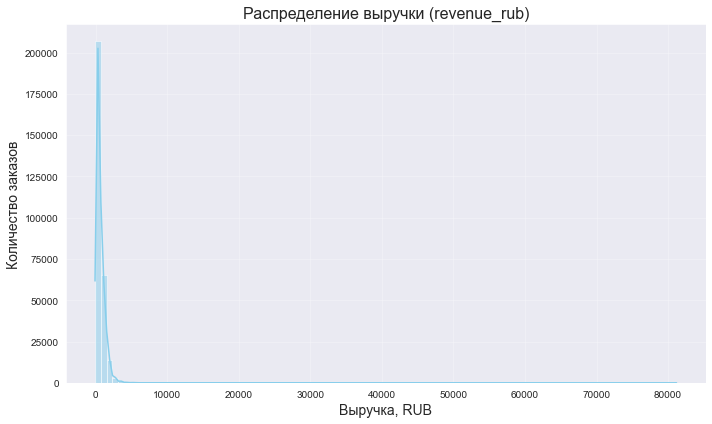

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['revenue_rub'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Распределение выручки (revenue_rub)', fontsize=16)
plt.xlabel('Выручка, RUB', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


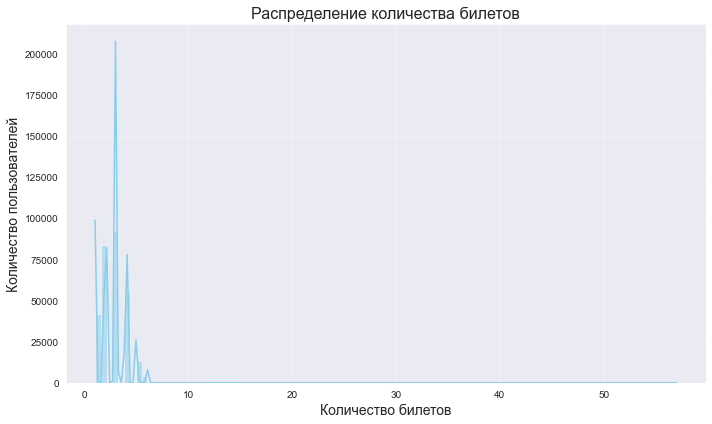

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['tickets_count'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Распределение количества билетов', fontsize=16)
plt.xlabel('Количество билетов', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


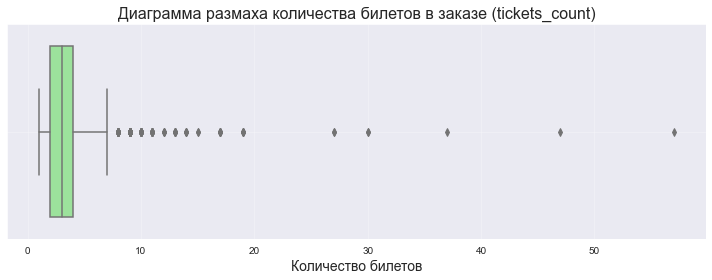

In [162]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df['tickets_count'].dropna(), color='lightgreen')
plt.title('Диаграмма размаха количества билетов в заказе (tickets_count)', fontsize=16)
plt.xlabel('Количество билетов', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

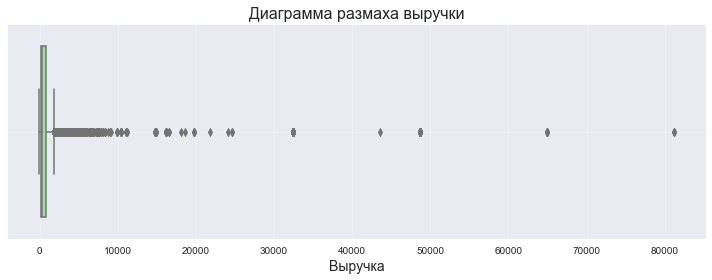

In [163]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df['revenue_rub'].dropna(), color='lightgreen')
plt.title('Диаграмма размаха выручки', fontsize=16)
plt.xlabel('Выручка', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Промежуточный вывод
- Выручка (revenue_rub):

Средняя выручка ~555 руб., медиана ~351 руб., что говорит о асимметричном распределении с длинным хвостом справа (есть высокие значения).

Минимальное значение отрицательное (-90,76 руб.) — это ошибка данных, которую нужно обработать (например, удалить или заменить на NaN).

Максимальная выручка (81 174 руб.) сильно превышает 99-й перцентиль (2 628 руб.), что указывает на явные выбросы.

- Количество билетов (tickets_count):

Среднее ~2.75 билета на заказ, медиана 3 билета.

Есть единичные выбросы (максимум 57 билетов), превышающие 99-й перцентиль (6 билетов), которые тоже можно считать аномалиями для анализа.

Удалим строки, в которых revenue_rub меньше нуля, а также отфильтруем по 99-ому процентелю, чтобы избавиться от выбросов в большую сторону.


In [164]:
df_clean = df[df['revenue_rub'] > 0].copy()

In [165]:
# Проверка количества строк с отрицательной выручкой
len(df_clean[df_clean['revenue_rub'] < 0])

0

In [166]:
# Найдем 99-ый процентиль
p99_revenue = df_clean['revenue_rub'].quantile(0.99)

In [167]:
df_clean = df_clean[df_clean['revenue_rub'] <= p99_revenue].copy()

In [168]:
print(f'Исходное количество строк: {len(df)}')
print(f'После удаления revenue < 0: {len(df[df["revenue_rub"] >= 0])}')
print(f'После фильтрации по 99 процентелю: {len(df_clean)}')

print(
    f'Удалено строк всего: {len(df) - len(df_clean)} '
    f'({(len(df) - len(df_clean)) / len(df):.2%})'
)

Исходное количество строк: 290611
После удаления revenue < 0: 290230
После фильтрации по 99 процентелю: 281879
Удалено строк всего: 8732 (3.00%)


# Создание профиля пользователей

In [169]:
# Сортировка по дате
df_clean = df_clean.sort_values(['user_id', 'created_ts_msk'])

In [170]:
# Создание нового датасета
user_profile = df_clean.groupby('user_id').agg(
        first_order_dt=('created_ts_msk', 'min'),
        last_order_dt=('created_ts_msk', 'max'),

        first_device=('device_type_canonical', 'first'),
        first_region=('region_name', 'first'),
        first_partner=('service_name', 'first'),
        first_event_genre=('event_type_main', 'first'),

        orders_cnt=('created_ts_msk', 'count'),
        avg_revenue=('revenue_rub', 'mean'),
        avg_tickets=('tickets_count', 'mean')
    ).reset_index()

In [171]:
user_profile['time_diff'] = (
    df_clean
    .groupby('user_id')['created_ts_msk']
    .diff()
    .dt.total_seconds() / 3600 / 24  # в днях
)


In [172]:
avg_time_between = (
    user_profile
    .groupby('user_id')['time_diff']
    .mean()
    .reset_index(name='avg_time_between_orders')
)

In [173]:
user_profile = user_profile.merge(
    avg_time_between,
    on='user_id',
    how='left'
)

In [174]:
user_profile['is_two'] = (user_profile['orders_cnt'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_cnt'] >= 5).astype(int)


In [175]:
user_profile = user_profile.drop(columns='time_diff')

In [176]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_event_genre,orders_cnt,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,NaN,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,74.805301,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,83.119757,1,0


In [177]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21700 entries, 0 to 21699
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21700 non-null  object        
 1   first_order_dt           21700 non-null  datetime64[ns]
 2   last_order_dt            21700 non-null  datetime64[ns]
 3   first_device             21700 non-null  object        
 4   first_region             21700 non-null  object        
 5   first_partner            21700 non-null  object        
 6   first_event_genre        21700 non-null  object        
 7   orders_cnt               21700 non-null  int64         
 8   avg_revenue              21700 non-null  float64       
 9   avg_tickets              21700 non-null  float64       
 10  avg_time_between_orders  20049 non-null  float64       
 11  is_two                   21700 non-null  int32         
 12  is_five                  21700 n

# Найдем данные по пользователям

In [178]:
print(f"Всего пользователей: {len(user_profile)}")

Всего пользователей: 21700


In [179]:
avg_revenue_per_order = user_profile['avg_revenue'].mean()
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order}")

Средняя выручка с одного заказа: 551.8789863451586


In [180]:
print(f"Доля пользователей с 2 и более заказами: {user_profile['is_two'].sum() / len(user_profile): .2%}")

Доля пользователей с 2 и более заказами:  61.67%


In [181]:
print(f"Доля пользователей с 5 и более заказами: {user_profile['is_five'].sum() / len(user_profile): .2%}")

Доля пользователей с 5 и более заказами:  28.87%


# Изучим статистические показатели

In [182]:
user_profile[['orders_cnt', 'avg_tickets', 'avg_time_between_orders']].describe()

,orders_cnt,avg_tickets,avg_time_between_orders
count,21700.000000,21700.000000,20049.000000
mean,12.989816,2.746006,1.746997
std,119.766778,0.914290,8.263856
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,0.001979
50%,2.000000,2.750000,0.013472
75%,5.000000,3.090909,0.115046
max,9987.000000,11.000000,137.177859


In [183]:
user_profile[[
    'orders_cnt',
    'avg_tickets',
    'avg_time_between_orders'
]].quantile([0.5, 0.9, 0.95, 0.99])

,orders_cnt,avg_tickets,avg_time_between_orders
0.50,2.00,2.75,0.013472
0.90,15.00,4.00,1.853000
0.95,31.00,4.00,8.208238
0.99,150.01,5.00,41.190789


## Статистические показатели по среднему числу билетов в принципе без отклонений, чего не скажешь о показателях по количеству заказов. В показателях по дням между заказами выделяется только максимальное значение - 137, но оно вполне является реалистичным (просто пользователь долго не делал заказ).
## В итоге в показателях по числу заказов: сильно выделяется максимальное значение - 9987, из-за чего достаточно большое СКО - около 120. Принят вывод о фильтрации данных по 95-тому процентелю.

In [184]:
p99_orders = user_profile['orders_cnt'].quantile(0.99)

user_profile_filtered = user_profile[user_profile['orders_cnt'] <= p99_orders].copy()

In [185]:
user_profile_filtered[['orders_cnt', 'avg_tickets', 'avg_time_between_orders']].describe()

,orders_cnt,avg_tickets,avg_time_between_orders
count,21483.000000,21483.000000,19852.000000
mean,6.404506,2.746183,1.743779
std,13.982574,0.918756,8.251109
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,0.001979
50%,2.000000,2.750000,0.013576
75%,5.000000,3.111111,0.115084
max,150.000000,11.000000,137.177859


In [186]:
print(f"Строк до фильтрации по 95-ому процентелю: {len(user_profile)}")
print(f"Строк после фильтрации по 95-ому процентелю: {len(user_profile_filtered)}")
print(f"Удалено строк: {len(user_profile) - len(user_profile_filtered)}")

Строк до фильтрации по 95-ому процентелю: 21700
Строк после фильтрации по 95-ому процентелю: 21483
Удалено строк: 217


### После фильтрации данные имеют намного меньше отклонений, все статистические показатели можно увидеть в выведенной таблице выше.

# Исследовательский анализ данных

In [187]:
# Группировка по типу первого мероприятия
total_users = len(user_profile_filtered)

grouped_by_first_genre = user_profile_filtered.groupby('first_event_genre').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_genre['share'] = grouped_by_first_genre['users_count'] / total_users
grouped_by_first_genre

,users_count,share
first_event_genre,,
концерты,9607,0.447191
другое,5223,0.243122
театр,4259,0.198250
стендап,1117,0.051995
спорт,765,0.035610
выставки,415,0.019318
ёлки,97,0.004515


In [188]:
# Группировка по типу устройства, с которого совершен первый заказ
grouped_by_first_device = user_profile_filtered.groupby('first_device').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_device['share'] = grouped_by_first_device['users_count'] / total_users
grouped_by_first_device

,users_count,share
first_device,,
mobile,17802,0.828655
desktop,3681,0.171345


In [189]:
# Группировка по типу первого региона
grouped_by_first_region = user_profile_filtered.groupby('first_region').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_region['share'] = grouped_by_first_region['users_count'] / total_users
print(grouped_by_first_region)

                          users_count     share
first_region                                   
каменевский регион               6973  0.324582
североярская область             3783  0.176093
широковская область              1234  0.057441
озернинский край                  678  0.031560
малиновоярский округ              527  0.024531
...                               ...       ...
залесский край                      2  0.000093
тихогорская область                 2  0.000093
верхозёрский край                   1  0.000047
сосноводолинская область            1  0.000047
яснопольский округ                  1  0.000047

[81 rows x 2 columns]


In [190]:
# Группировка по типу первого оператора
grouped_by_first_partner = user_profile_filtered.groupby('first_partner').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_partner['share'] = grouped_by_first_partner['users_count'] / total_users
print(grouped_by_first_partner)

                        users_count     share
first_partner                                
билеты без проблем             4968  0.231253
мой билет                      2996  0.139459
лови билет!                    2801  0.130382
билеты в руки                  2548  0.118605
облачко                        2196  0.102220
весь в билетах                 1291  0.060094
лучшие билеты                  1183  0.055067
прачечная                       586  0.027277
край билетов                    460  0.021412
дом культуры                    358  0.016664
яблоко                          320  0.014895
тебе билет!                     310  0.014430
городской дом культуры          218  0.010148
мир касс                        213  0.009915
за билетом!                     204  0.009496
быстробилет                     165  0.007680
show_ticket                     157  0.007308
выступления.ру                   95  0.004422
восьмёрка                        86  0.004003
быстрый кассир                   6

### - По типу первого мероприятия выделяется сегмент с наибольшим числом пользователей - это концерты, составляет 44%, следующий во величине - всего 24.
### - По типу первого устройства выделяются мобильные телефоны - 83%.
### - По типу первого региона - каменевский регион, 32%, следующий по величине всего 17%.
### - По типу первого оператора данные распределены наиболее равномерно, есть один наиболее выделяющийся оператор - билеты без проблем (23%), но есть также еще около 6 операторов, которые имеют распределение от 5 до 13 %. Однако, данные все так же распределены неравномерно.

### В итоге, можно сделать вывод, что в каждом сегменте данные распределены неравномерно, везде есть выделяющийся сегмент с наибольшим числом пользователей.

In [191]:
# Анализ возврата пользователей

In [192]:
# Доля возврата пользователей по всему датасету
baseline_return_rate = user_profile_filtered['is_two'].mean()
round(baseline_return_rate, 4)

0.6128

In [193]:
# Универсальная функция для сегментов
def segment_return_rate(df, segment_col):
    segment_stats = (
        df.groupby(segment_col).agg(users_cnt=('user_id', 'count'), return_rate=('is_two', 'mean')).sort_values('users_cnt', ascending=False).reset_index()
    )

    return segment_stats

In [194]:
# По первому событию

event_return = segment_return_rate(user_profile_filtered, 'first_event_genre')
event_return

,first_event_genre,users_cnt,return_rate
0,концерты,9607,0.617779
1,другое,5223,0.594294
2,театр,4259,0.634891
3,стендап,1117,0.608774
4,спорт,765,0.549020
5,выставки,415,0.643373
6,ёлки,97,0.567010


In [195]:
# По первому устройству

device_return = segment_return_rate(user_profile_filtered, 'first_device')
device_return

,first_device,users_cnt,return_rate
0,mobile,17802,0.608078
1,desktop,3681,0.635697


In [196]:
# По первому событию

region_return = segment_return_rate(user_profile_filtered, 'first_region')
region_return.head(10)

,first_region,users_cnt,return_rate
0,каменевский регион,6973,0.619102
1,североярская область,3783,0.640497
2,широковская область,1234,0.645057
3,озернинский край,678,0.551622
4,малиновоярский округ,527,0.557875
5,шанырский регион,465,0.694624
6,светополянский округ,461,0.657267
7,травяная область,461,0.616052
8,речиновская область,445,0.638202
9,яблоневская область,411,0.593674


In [197]:
# По первому событию

partner_return = segment_return_rate(user_profile_filtered, 'first_partner')
partner_return.head(10)

,first_partner,users_cnt,return_rate
0,билеты без проблем,4968,0.597625
1,мой билет,2996,0.607810
2,лови билет!,2801,0.611210
3,билеты в руки,2548,0.629513
4,облачко,2196,0.613388
5,весь в билетах,1291,0.628970
6,лучшие билеты,1183,0.614539
7,прачечная,586,0.626280
8,край билетов,460,0.654348
9,дом культуры,358,0.648045


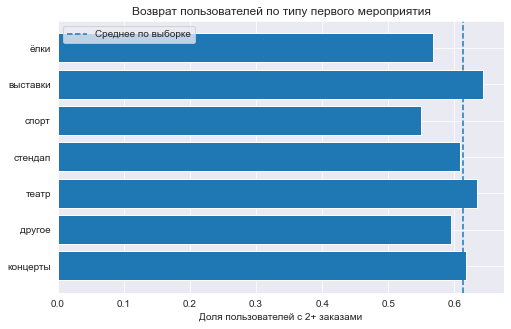

In [198]:
plt.figure(figsize=(8, 5))
plt.barh(
    event_return['first_event_genre'],
    event_return['return_rate']
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по типу первого мероприятия')
plt.legend()
plt.show()

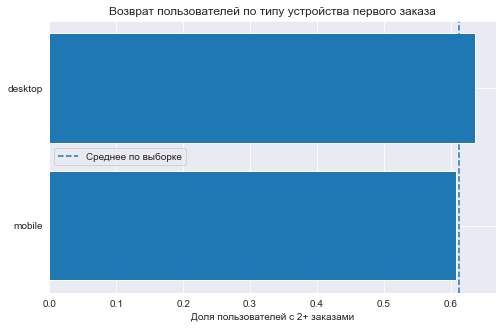

In [199]:
plt.figure(figsize=(8, 5))
plt.barh(
    device_return['first_device'],
    device_return['return_rate']
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по типу устройства первого заказа')
plt.legend()
plt.show()

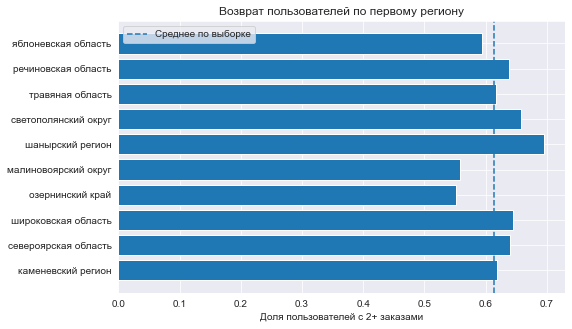

In [200]:
plt.figure(figsize=(8, 5))
plt.barh(
    region_return['first_region'].head(10),
    region_return['return_rate'].head(10)
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по первому региону')
plt.legend()
plt.show()

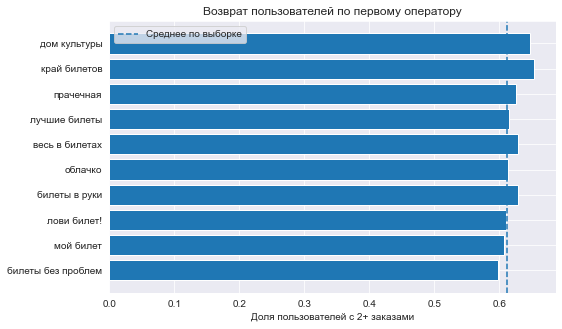

In [201]:
plt.figure(figsize=(8, 5))
plt.barh(
    partner_return['first_partner'].head(10),
    partner_return['return_rate'].head(10)
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по первому оператору')
plt.legend()
plt.show()

### В данных наблюдаются **успешные точки входа**, где пользователи возвращаются чаще среднего по выборке (**61,67%**):

### * **Театральные мероприятия** как первый опыт использования сервиса - доля повторных заказов **63,49%** при **4,3 тыс. пользователей**.
### * **Десктоп** как устройство первого заказа - **63,57%** при **3,7 тыс. пользователей**, что выше, чем у мобильных устройств (**60,81%**).
### * **Отдельные крупные регионы**, например **Североярская область** (**64,05%**, 3,8 тыс. пользователей) и **Широковская область** (**64,51%**, 1,2 тыс. пользователей).
### * **Ряд билетных операторов**, в частности **«Билеты в руки»** (**62,95%**, 2,5 тыс. пользователей) и **«Весь в билетах»** (**62,90%**, 1,3 тыс. пользователей).

### Сегменты с небольшим числом пользователей (сотни и менее), несмотря на более высокие значения доли возврата (до **65–69%**), не рассматриваются как статистически надёжные без дополнительной проверки.


## Проверка гипотез.
### Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

#### Нет, пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ реже, чем пользователи, оформившие свой первый заказ на концерты, ведь вероятность возврата на жанре "спорт" - 0.549, а вероятность возврата на жанре "концерты" - 0.6178

#### Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.
#### Возьмем топ 3 больших региона
#### - Каменевский регион - 6 973 пользователя, возврат 61,91%
#### - Североярская область — 3 783 пользователя, возврат 64,05%
#### - Широковская область — 1 234 пользователя, возврат 64,51%
#### Менее активные регионы:
#### - Озернинский край — 678 пользователей, возврат 55,16%
#### - Малиновоярский округ — 527 пользователей, возврат 55,79%
#### При этом в отдельных малых регионах (например, Шанырский регион, 465 пользователей) наблюдается высокий возврат (69,46%), но из-за небольшого размера сегмента такие значения могут быть нестабильными.
#### В целом гипотеза подтверждается частично, если не считать маленькие регионы, ведь данные по ним нестабильны.

# Исследование поведения пользователей через показатели выручки и состава заказа

In [202]:
one_order_users = user_profile_filtered[user_profile_filtered['is_two'] == 0]['avg_revenue']
repeat_users = user_profile_filtered[user_profile_filtered['is_two'] == 1]['avg_revenue']

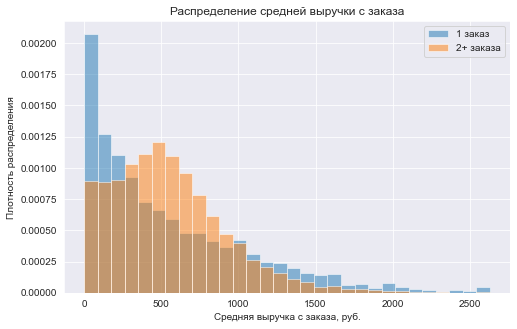

In [203]:
plt.figure(figsize=(8, 5))

plt.hist(
    one_order_users,
    bins=30,
    alpha=0.5,
    density=True,
    label='1 заказ'
)

plt.hist(
    repeat_users,
    bins=30,
    alpha=0.5,
    density=True,
    label='2+ заказа'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа')
plt.legend()
plt.show()

#### Пользователи с одним заказом (синим цветом)
#### Пик распределения - примерно 0–300 руб.
#### Большинство пользователей в этой группе делают небольшие по стоимости заказы.
#### Вернувшиеся пользователи (2+ заказа) (коричневым цветом)
#### Пик распределения - примерно 400–700 руб.
#### Распределение смещено вправо, есть более крупные заказы (500–1000 руб.) и длинный хвост вплоть до 2500+ руб.

In [204]:
# 2–4 заказа
group_2_4 = user_profile_filtered[(user_profile_filtered['orders_cnt'] >= 2) & (user_profile_filtered['orders_cnt'] <= 4)]['avg_revenue']

# 5+ заказов
group_5_plus = user_profile_filtered[user_profile_filtered['orders_cnt'] >= 5]['avg_revenue']

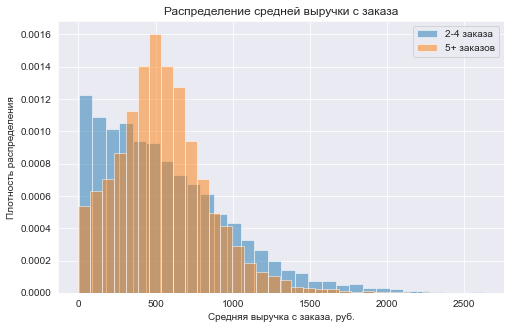

In [205]:
plt.figure(figsize=(8, 5))

plt.hist(
    group_2_4,
    bins=30,
    alpha=0.5,
    density=True,
    label='2-4 заказа'
)

plt.hist(
    group_5_plus,
    bins=30,
    alpha=0.5,
    density=True,
    label='5+ заказов'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа')
plt.legend()
plt.show()

#### Пользователи с 2-4 заказами (синим цветом)
#### Пик распределения - примерно 0–400 руб. Больше всего заказов со стоимостью 0-100.
#### Большинство пользователей в этой группе делают небольшие по стоимости заказы (чаще всего 0-400 рублей), также имеет хвост вправо вплоть до 2300 руб.
#### 5+ заказов (коричневым цветом)
#### Пик распределения - примерно 400–700 руб. Больше всего заказов со стоимостью 500.
#### Распределение смещено вправо и также имеет хвост вплоть до 1700+ руб.

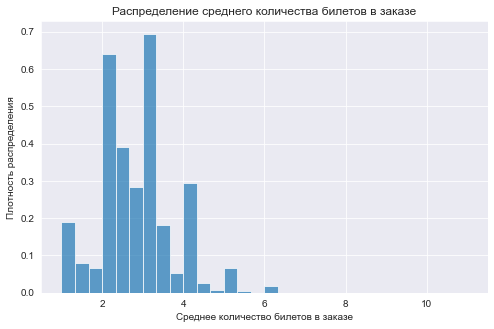

In [206]:
plt.figure(figsize=(8, 5))
plt.hist(user_profile_filtered['avg_tickets'], bins=30, density=True, alpha=0.7)
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Плотность распределения')
plt.title('Распределение среднего количества билетов в заказе')
plt.show()

In [207]:
user_profile_filtered['avg_tickets'].describe()

count    21483.000000
mean         2.746183
std          0.918756
min          1.000000
25%          2.000000
50%          2.750000
75%          3.111111
max         11.000000
Name: avg_tickets, dtype: float64

In [208]:
print(user_profile_filtered['avg_tickets'].mode())

0    3.0
dtype: float64


In [209]:
user_profile_filtered['avg_tickets'].value_counts().head(10)

3.000000    4140
2.000000    3718
4.000000    2045
1.000000    1326
2.500000    1148
3.500000     659
2.666667     530
5.000000     463
2.333333     458
1.500000     415
Name: avg_tickets, dtype: int64

#### Самое часто встречающееся число билетов в заказе - 3, следующее по количеству - 2.
#### Распределение смещено вправо, имеется два больших пика в двойке и тройке. Минимальное значение - 1, маусимальное - 11.

In [210]:
user_profile_filtered['tickets_segment'] = pd.cut(
    user_profile_filtered['avg_tickets'],
    bins=[1, 2, 3, 5, 11],
    right=True,
    include_lowest=True,
    labels=[
        '1–2 билета',
        '2–3 билета',
        '3–5 билетов',
        '5+ билетов'
    ]
)
user_profile_filtered.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_event_genre,orders_cnt,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,tickets_segment
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3–5 билетов
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,NaN,1,0,2–3 билета
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,74.805301,1,0,2–3 билета
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3–5 билетов
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,83.119757,1,0,1–2 билета


In [211]:
segment_stats = user_profile_filtered.groupby('tickets_segment').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
)
segment_stats

,users_count,returned_share
tickets_segment,,
1–2 билета,6109,0.400229
2–3 билета,9833,0.742195
3–5 билетов,5347,0.628203
5+ билетов,194,0.324742


#### Пользователи распределены по сегментам неравномерно. Самое большое количество пользователей в сегменте 2-3 билета (9833), а самое маленькое в 5+ билетов, что логично, ведь цена на 5+ билетов не всем "под силу".
#### Нельзя сказать, что есть сегменты с аномально низкой или аномально высокой долей повторных покупок, однако в сегменте 2-3 билета, доля повторных покупок самая большая - 0.74

# 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

In [212]:
user_profile_filtered['first_order_weekday'] = user_profile_filtered['first_order_dt'].dt.day_name()
user_profile_filtered.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_event_genre,orders_cnt,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,tickets_segment,first_order_weekday
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3–5 билетов,Tuesday
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,NaN,1,0,2–3 билета,Tuesday
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,74.805301,1,0,2–3 билета,Saturday
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3–5 билетов,Thursday
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,83.119757,1,0,1–2 билета,Sunday


In [213]:
weekday_stats = (
    user_profile_filtered
    .groupby('first_order_weekday')
    .agg(users_cnt=('user_id', 'count'), returned_share=('is_two', 'mean'))
    .reset_index()
    .sort_values(by='users_cnt', ascending=False)

)
weekday_stats

,first_order_weekday,users_cnt,returned_share
2,Saturday,3292,0.627886
0,Friday,3230,0.599071
5,Tuesday,3157,0.617358
4,Thursday,3098,0.594900
6,Wednesday,3048,0.621719
1,Monday,2901,0.626336
3,Sunday,2757,0.601741


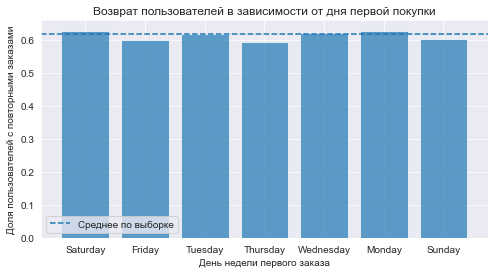

In [214]:
plt.figure(figsize=(8, 4))
plt.bar(
    weekday_stats['first_order_weekday'],
    weekday_stats['returned_share'],
    alpha=0.7
)
plt.axhline(
    y=user_profile['is_two'].mean(),
    linestyle='--',
    label='Среднее по выборке'
)
plt.ylabel('Доля пользователей с повторными заказами')
plt.xlabel('День недели первого заказа')
plt.title('Возврат пользователей в зависимости от дня первой покупки')
plt.legend()
plt.show()


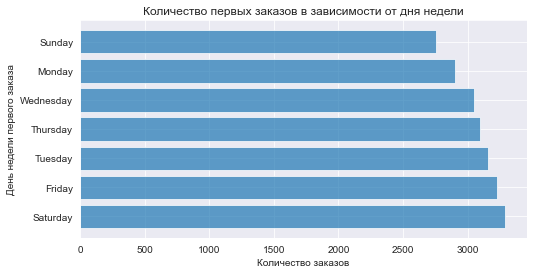

In [215]:
plt.figure(figsize=(8, 4))
plt.barh(
    weekday_stats['first_order_weekday'],
    weekday_stats['users_cnt'],
    alpha=0.7
)
plt.xlabel('Количество заказов')
plt.ylabel('День недели первого заказа')
plt.title('Количество первых заказов в зависимости от дня недели')
plt.show()


#### По результатам анализа понятно, что день недели, в который совершена первая покупка, не влияет на то, вернется ли пользователь, ведь вероятность возврата почти в каждый день недели равна около 60%

In [216]:
group_2_4 = user_profile_filtered[
    (user_profile_filtered['orders_cnt'] >= 2) &
    (user_profile_filtered['orders_cnt'] <= 4)
]

group_5_plus = user_profile_filtered[
    user_profile_filtered['orders_cnt'] >= 5
]

In [217]:
interval_stats = pd.DataFrame({
    'group': ['2–4 заказа', '5+ заказов'],
    'users_cnt': [
        group_2_4.shape[0],
        group_5_plus.shape[0]
    ],
    'avg_days_between_orders': [
        group_2_4['avg_time_between_orders'].mean(),
        group_5_plus['avg_time_between_orders'].mean()
    ]
})

interval_stats

,group,users_cnt,avg_days_between_orders
0,2–4 заказа,7118,1.778240
1,5+ заказов,6047,1.640694


#### Среднее время заказов почти не отличается для двух групп

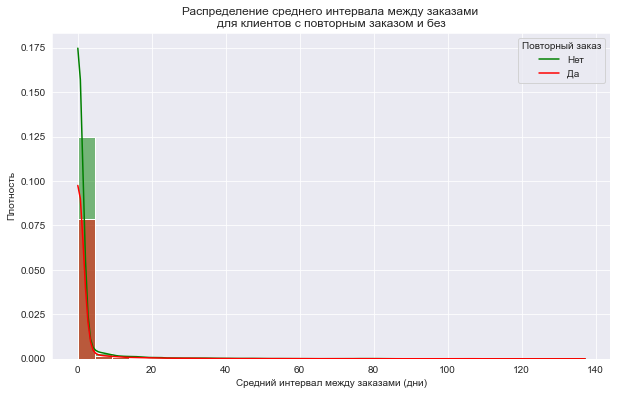

In [218]:
plt.figure(figsize=(10,6))
sns.histplot(data=user_profile_filtered, x='avg_time_between_orders', hue='is_two',
             bins=30, kde=True, stat='density', palette=['red','green'], alpha=0.5)

plt.xlabel('Средний интервал между заказами (дни)')
plt.ylabel('Плотность')
plt.title('Распределение среднего интервала между заказами \nдля клиентов с повторным заказом и без')
plt.legend(title='Повторный заказ', labels=['Нет','Да'])
plt.show()

In [219]:
bins = [0, 30, 60, 90, np.inf]
labels = ['<=30_days', '31-60_days', '61-90_days', '>90_days']
user_profile_filtered['interval_group'] = pd.cut(user_profile_filtered['avg_time_between_orders'], bins=bins, labels=labels, right=True)


In [220]:
repeat_probs = user_profile_filtered.groupby('interval_group')['is_two'].mean().reset_index()
repeat_probs.rename(columns={'is_two': 'repeat_probability'}, inplace=True)

In [221]:
repeat_probs

,interval_group,repeat_probability
0,<=30_days,0.613060
1,31-60_days,0.598039
2,61-90_days,0.594595
3,>90_days,0.558824


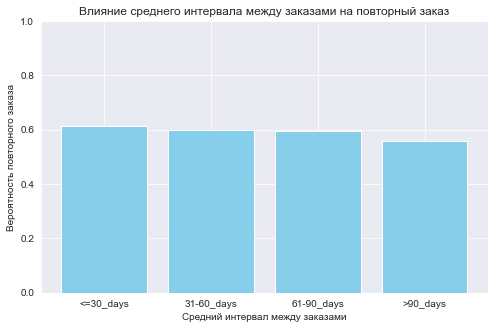

In [222]:
plt.figure(figsize=(8,5))
plt.bar(repeat_probs['interval_group'], repeat_probs['repeat_probability'], color='skyblue')
plt.xlabel('Средний интервал между заказами')
plt.ylabel('Вероятность повторного заказа')
plt.title('Влияние среднего интервала между заказами на повторный заказ')
plt.ylim(0,1)
plt.show()


#### В целом, интервал между заказами почти не влияет на вероятность повторного заказа, но небольшая зависимость виднеется - чем меньше интервал, тем больше вероятность на повторный заказ.

In [223]:
interval_cols = ['orders_cnt', 'avg_revenue', 'avg_tickets', 'avg_time_between_orders', 'is_two']

In [224]:
df_phik = user_profile_filtered.drop(columns=['first_order_dt', 'last_order_dt', 'user_id'])

In [225]:
phik_m = df_phik.phik_matrix(interval_cols=interval_cols)

In [226]:
print(phik_m['orders_cnt'].sort_values(ascending=False).drop('orders_cnt'))

is_five                    0.636809
is_two                     0.319584
avg_tickets                0.230616
avg_revenue                0.225704
tickets_segment            0.216721
first_region               0.124709
first_order_weekday        0.053428
first_partner              0.030954
first_event_genre          0.028761
first_device               0.015655
avg_time_between_orders    0.000000
interval_group             0.000000
Name: orders_cnt, dtype: float64


In [227]:
df_phik['orders_segment'] = pd.cut(
    df_phik['orders_cnt'],
    bins=[0, 1, 4, df_phik['orders_cnt'].max()],
    labels=['1_order', '2_4_orders', '5+_orders']
)

In [228]:
phi_k_segments = {}

for seg in df_phik['orders_segment'].unique():
    seg_df = df_phik[df_phik['orders_segment'] == seg]
    phi_k_segments[seg] = seg_df.phik_matrix(interval_cols=interval_cols)


C:\ProgramData\Anaconda3\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable orders_cnt for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable orders_segment for analysis 1. Dropping this column
  warnings.warn(


In [229]:
print(phi_k_segments['2_4_orders']['orders_cnt'].sort_values(ascending=False).drop('orders_cnt'))

avg_tickets                0.367639
avg_revenue                0.110113
tickets_segment            0.091899
first_partner              0.056978
first_device               0.007180
first_region               0.000000
first_event_genre          0.000000
avg_time_between_orders    0.000000
first_order_weekday        0.000000
interval_group             0.000000
Name: orders_cnt, dtype: float64


In [230]:
print(phi_k_segments['5+_orders']['orders_cnt'].sort_values(ascending=False).drop('orders_cnt'))

avg_revenue                0.235368
tickets_segment            0.202662
first_region               0.179260
avg_tickets                0.162565
first_order_weekday        0.094639
first_event_genre          0.040999
first_device               0.000000
first_partner              0.000000
avg_time_between_orders    0.000000
interval_group             0.000000
Name: orders_cnt, dtype: float64


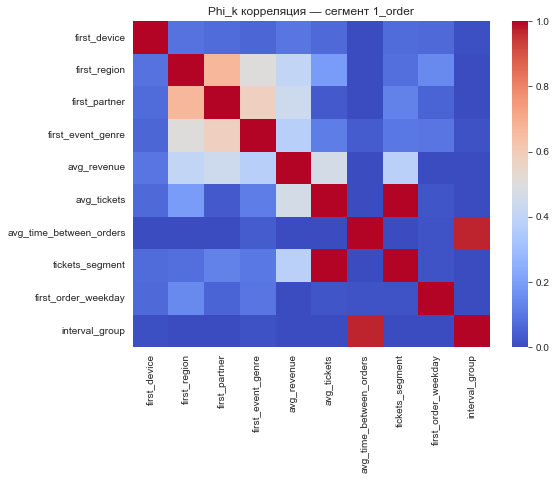

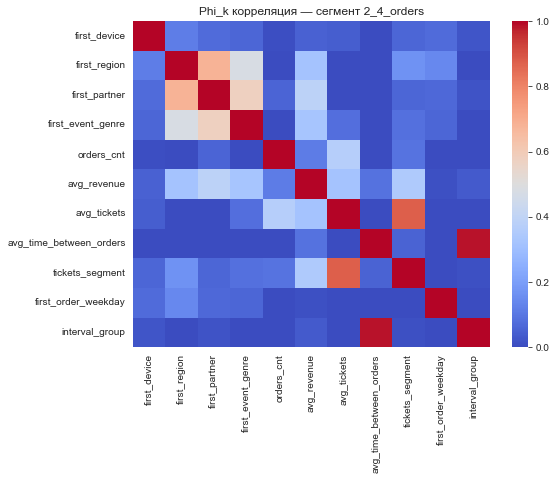

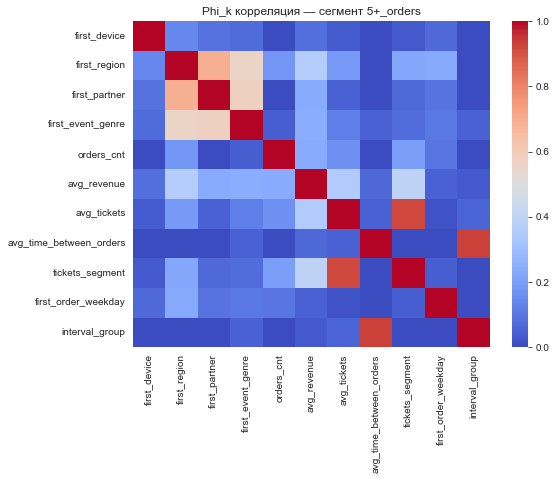

In [231]:
for seg, corr in phi_k_segments.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr,
        cmap='coolwarm',
        vmin=0,
        vmax=1,
        annot=False
    )
    plt.title(f'Phi_k корреляция — сегмент {seg}')
    plt.show()

#### Без разделения на сегменты наиболее связаны с количеством заказов такие столбцы: is_five, is_two, avg_tickets, avg_revenue, tickets_segment, first_region
#### - С разделением на сегменты: при сегменте с одним заказом невозможно проследить корреляцию, ведь количество заказов является константой.
#### - При количестве заказов 2-4 наиболее связаны: avg_tickets, avg_revenue, tickets_segment, first_partner
#### - При количестве заказов 5+ наиболее связаны: avg_revenue, tickets_segment, first_region, avg_tickets, first_order_weekday

## Общий вывод

### Данные и подготовка

В работе использовались данные о заказах пользователей билетного сервиса: информация о первом заказе, профиле пользователя, количестве заказов, выручке, количестве билетов и временных характеристиках.
Перед анализом данные были подготовлены:

* выручка приведена к единой валюте (рубли);
* построен профиль пользователей на уровне 'user_id';
* отфильтрованы выбросы по количеству заказов и средним интервалам между покупками;
* рассчитаны дополнительные признаки: средняя выручка, среднее число билетов, интервалы между заказами, признаки повторных покупок;
* пользователи сегментированы по количеству заказов.

После очистки данные стали более устойчивыми, без аномальных значений, что позволило корректно проводить дальнейший анализ.

### Основные результаты анализа

**Общая структура данных**

* В выборке преобладают пользователи с **одним заказом**, что создаёт сильный перекос в распределении `total_orders`.
* Пользователи с 2–4 и 5+ заказами составляют меньшую, но наиболее ценную с точки зрения бизнеса часть аудитории.
* Были изучены ключевые статистики: среднее число заказов, средний чек, количество билетов, интервалы между покупками.

**Возврат пользователей**

* Вероятность повторного заказа выше у пользователей с:

  * более высоким средним чеком;
  * большим количеством билетов в заказе;
  * меньшими интервалами между покупками.
* Первый заказ играет важную роль в формировании дальнейшего поведения.

**Связь выручки и состава заказа с повторными покупками**

* Средняя выручка и среднее количество билетов в заказе умеренно связаны с вероятностью повторных покупок.
* Пользователи, которые сразу покупают больше билетов или более дорогие билеты, чаще возвращаются.

**Временные характеристики**

* Интервалы между заказами являются одним из ключевых факторов удержания: чем они меньше, тем выше вероятность повторной покупки.
* День недели первого заказа влияет слабо, но в данных есть дни, которые можно считать более «успешными точками входа».

**Корреляционный анализ**

* Профильные признаки (устройство, партнёр, жанр первого события) слабо связаны с числом заказов.
* Наибольшую связь с количеством заказов показывают **поведенческие признаки**, а не характеристики профиля.
* Из-за преобладания пользователей с одним заказом корреляция на всей выборке занижена, поэтому была проведена сегментация по числу заказов.
* В сегментах с 2–4 и 5+ заказами зависимости между поведенческими признаками становятся заметно сильнее.

## Итоговые выводы

* Основной фактор роста числа заказов — **поведение пользователя**, а не его демографический или технический профиль.
* Первый заказ критически важен: именно он задаёт дальнейший сценарий взаимодействия пользователя с сервисом.
* Пользователи с одним заказом сильно «размывают» корреляционные зависимости, но именно они являются главным резервом роста.


## Рекомендации заказчику

1. **Сфокусироваться на пользователях с 1 заказом**
   Это самый массовый сегмент и основной источник потенциального роста. Для них стоит:

   * запускать триггерные коммуникации после первого заказа;
   * стимулировать повторную покупку в короткий срок.

2. **Усилить работу с сегментом 2–4 заказа**
   Это переходный сегмент, где поведенческие паттерны уже формируются:

   * персональные предложения;
   * бонусы за повторные покупки;
   * рекомендации похожих мероприятий.

3. **Закреплять лояльность пользователей с 5+ заказами**
   Это наиболее ценные клиенты:

   * программы лояльности;
   * ранний доступ к мероприятиям;
   * персонализированные подборки.

4. **Оптимизировать первый заказ**
   Стоит стимулировать:

   * покупку большего количества билетов;
   * более вовлекающий первый опыт (успешные жанры и форматы).

В целом результаты показывают, что рост удержания и числа заказов достигается не за счёт изменения профиля пользователя, а за счёт управления пользовательским поведением и качеством первого и повторных взаимодействий с сервисом.
